In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Ony necessary in MacOSX and Anaconda due to known error with duplicated symbol
# when using OpenMP
# This line can also be avoided installing anaconda's nomkl (conda install nomkl)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import egttools as egt

In [3]:
egt.numerical.Random.init()
seed = egt.numerical.Random.seed_

In [4]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [5]:
game = egt.numerical.games.NormalFormGame(1, A)

In [6]:
Z = 100
x = np.arange(0, Z+1)/Z

In [7]:
evolver = egt.numerical.PairwiseMoran(Z, game, 1000000)

In [8]:
Z = 100
x = np.arange(0, Z+1)/Z
evolver.pop_size = Z

In [9]:
dist = evolver.stationary_distribution(10, int(1e6), int(1e3), 1, 1e-3)

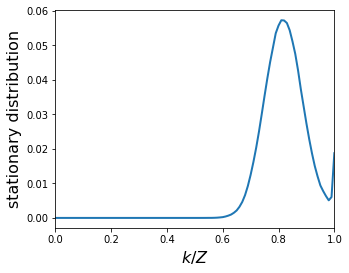

In [10]:
# We need to reverse, since in this case we are starting from the case
# where the number of Haws is 100%, because of how we map states
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
lines = ax.plot(x, list(reversed(dist)))
plt.setp(lines, linewidth=2.0)
ax.set_ylabel('stationary distribution',size=16)
ax.set_xlabel('$k/Z$',size=16)
ax.set_xlim(0, 1)
plt.show()

### We can also plot a single run

In [11]:
output = evolver.run(int(1e6), 1, 1e-3, [0, Z])

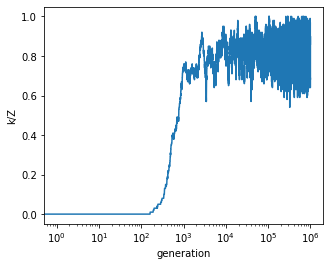

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(output[:, 0]/Z)
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')
plt.show()

### And can visualize what happens if we start several runs from random points in the simplex

In [13]:
init_states = np.random.randint(0, Z+1, size=10, dtype=np.uint64)

In [14]:
output = []
for i in range(10):
    output.append(evolver.run(int(1e6), 1, 1e-3, 
                              [init_states[i], Z - init_states[i]]))

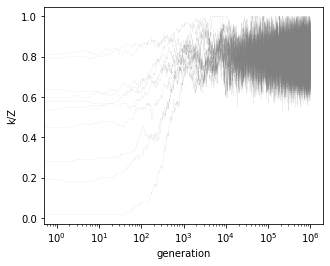

In [70]:
# Plot each year's time series in its own facet
fig, ax = plt.subplots(figsize=(5, 4))

for run in output:
    ax.plot(run[:, 0]/Z, color='gray', linewidth=.1, alpha=0.6) 
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')

### And we can also compare how far our approximations are from the analytical results

In [16]:
# We do this for different betas
betas = np.logspace(-4, 1, 50)

In [17]:
stationary_points = []
for i in range(len(betas)):
    stationary_points.append(evolver.stationary_distribution(30, int(1e6), int(1e3), 
                                                             betas[i], 1e-3))
stationary_points = np.asarray(stationary_points)

In [18]:
# Now we estimate the probability of Cooperation for each possible state
state_frequencies = np.arange(0, Z+1) / Z
coop_level = np.dot(state_frequencies, stationary_points.T)

In [19]:
# Finnally we do the same, but for the analytical results
from egttools.analytical import StochDynamics

In [20]:
analytical_evolver = egt.analytical.StochDynamics(2, A, Z, mu=1e-3)

In [21]:
stationary_points_analytical = []
for i in range(len(betas)):
    stationary_points_analytical.append(analytical_evolver.calculate_stationary_distribution(betas[i]))
stationary_points_analytical = np.asarray(stationary_points_analytical)

In [22]:
# Now we estimate the probability of Cooperation for each possible state
coop_level_analytical = np.dot(1 - state_frequencies, stationary_points_analytical.T)

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mse = mean_squared_error(coop_level_analytical, coop_level)

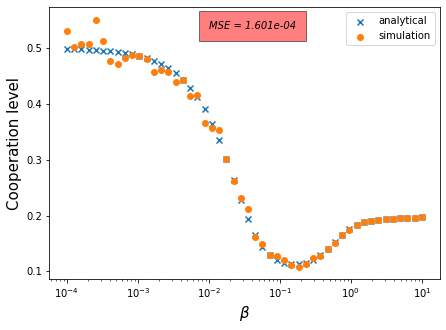

In [69]:
# Finally, we plot and compare visually (and check how much error we get)
fig, ax = plt.subplots(figsize=(7, 5))
# ax.scatter(betas, coop_level, label="simulation")
ax.scatter(betas, coop_level_analytical, marker='x', label="analytical")
ax.scatter(betas, coop_level, marker='o', label="simulation")
ax.text(0.01, 0.535, 'MSE = {0:.3e}'.format(mse), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.legend()
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel('Cooperation level', fontsize=15)
ax.set_xscale('log')
plt.show()